# 模板

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler


import torchvision
from torchvision import transforms
import os

from lxml import etree # 解析xml
from matplotlib.patches import Rectangle  # 绘制矩形
import glob

from PIL import Image

## 训练 fit
4个输出 xmin, ymin, xmax, ymax

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
def fit(epoch, model, trainloader, testloader):
    """输入模型、输入数据(train_dl, test_dl)， 对数据输入在模型上训练，并返回loss变化"""
    running_loss = 0
    model.train()  # 训练模式 dropout BN发挥作用
    for img, label in trainloader:
        img = img.to(device)
        label = label.to(device)
        y1, y2, y3, y4 = label[:,0], label[:,1], label[:,2], label[:,3]
        y1, y2, y3, y4 = (i.squeeze() for i in [y1, y2, y3, y4])  # 将(n,1)展平为一维(n)
        y_pred1, y_pred2, y_pred3, y_pred4 = model(img)
        loss1 = loss_fn(y_pred1, y1)
        loss2 = loss_fn(y_pred2, y2)
        loss3 = loss_fn(y_pred3, y3)
        loss4 = loss_fn(y_pred4, y4)
        loss = loss1 + loss2 + loss3 + loss4
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            running_loss += loss.item()

    lr_decay.step()  # 学习率衰减
    epoch_loss = running_loss / len(trainloader.dataset)  # 平均loss

    test_running_loss = 0
    model.eval()  # 预测模式 dropout BN不发挥作用
    with torch.no_grad():
        for img, label in testloader:
            img = img.to(device)
            label = label.to(device)
            y1, y2, y3, y4 = label[:,0], label[:,1], label[:,2], label[:,3]
            y1, y2, y3, y4 = (i.squeeze() for i in [y1, y2, y3, y4])  # 将(n,1)展平为一维(n)
            y_pred1, y_pred2, y_pred3, y_pred4 = model(img)
            loss1 = loss_fn(y_pred1, y1)
            loss2 = loss_fn(y_pred2, y2)
            loss3 = loss_fn(y_pred3, y3)
            loss4 = loss_fn(y_pred4, y4)
            loss = loss1 + loss2 + loss3 + loss4
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)

    print('epoch:', epoch,
          'loss:', round(epoch_loss, 3),
          'test_loss:', round(epoch_test_loss, 3),
             )

    return epoch_loss, epoch_test_loss

cuda:0


## 显示损失 show_loss
回归问题，没有必要计算准确率

In [63]:
def show_loss(train_loss, test_loss):
    plt.figure()
    plt.plot(range(1, epochs+1), train_loss, label='train_loss')
    plt.plot(range(1, epochs+1), test_loss, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()

## 显示图像 show_img

In [74]:
def show_img(dataloader, size=3, transform_size=224):
    """
    显示前6张图片
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小
    """
    imgs, labels = next(iter(dataloader))
    plt.figure(figsize=(6*size, 1*size))
    for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
        img = img.permute(1, 2, 0).numpy()  # 改变维度 toTensor的逆操作
        # img = (img+1)/2 # 从(-1,1)转化到(0,1)  标准化的逆操作
        plt.subplot(1, 6, i+1)  # 子图
        plt.imshow(img)  # 显示图片
        xmin, ymin, xmax, ymax = [i*transform_size for i in label]  # 转为实际的宽和高
        rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')  # 矩形框坐标
        ax = plt.gca()  # 获取当前坐标系
        ax.axes.add_patch(rect)  # 绘制矩形

# 图像定位
The Oxford-IIIT Pet Dataset是一个宠物图像数据集,包含37种宠物,每种宠物200张左右宠物图片,该数据集同时包含宠物分类、头部轮廊标注和语义分割信息。

## 数据预处理

In [75]:
images = glob.glob(r'data/Oxford-IIIT Pets Dataset/images/*.jpg')  # 7390
xmls = glob.glob(r"data/Oxford-IIIT Pets Dataset/annotations/xmls/*.xml")  # 部分有标记 3686
xmls_names = [x.split('\\')[-1].split('.xml')[0] for x in xmls]  # 所有有标记的图片名称
imgs = [img for img in images if img.split('\\')[-1].split('.jpg')[0] in xmls_names]  # 找到有标记的图片路径
# imgs,xmls 都是一一对应的，不需要排序

def to_labels(path):
    """从xml中读取标记的矩形框，返回比例值"""
    xml = open(r'{}'.format(path)).read()
    sel = etree.HTML(xml)  # 选择器
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]
labels = [to_labels(path) for path in xmls]  # 将xml内矩形提取出来转为label，比例表示

index = np.random.permutation(len(imgs))  # 打乱并划分训练集和测试集
imgs = np.array(imgs)[index]
labels = np.array(labels)[index].astype(np.float32)
s = int(len(imgs)*0.8)
train_imgs, train_labels = imgs[:s], labels[:s]
test_imgs, test_labels = imgs[s:], labels[s:]

# 创建DataSet
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
])
class OxfordDataset(Dataset):
    def __init__(self, img_paths, labels_list ,transform):
        self.imgs = img_paths  # 路径列表
        self.labels = labels_list
        self.transforms = transform
    def __getitem__(self, index):
        """返回img和对应的矩形框(比例表示)"""
        img = self.imgs[index]
        img_tensor = self.transforms(Image.open(img))
        labels = self.labels[index]
        return img_tensor, labels
    def __len__(self):
        return len(self.imgs)

train_ds = OxfordDataset(train_imgs, train_labels, transform)
test_ds = OxfordDataset(test_imgs, test_labels, transform)
BATCHSIZE=16
train_dl = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCHSIZE)

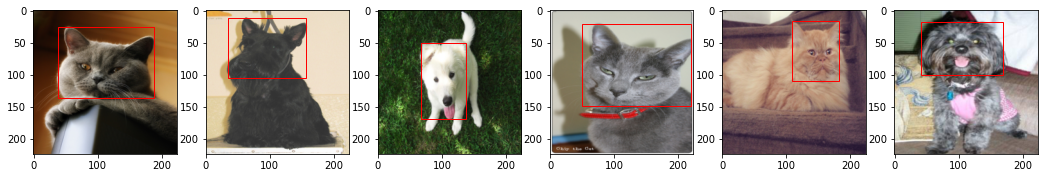

In [76]:
show_img(train_dl)  # 看看长啥样

## 创建定位模型

In [65]:
resnet = torchvision.models.resnet101(pretrained=True)  # avgpool前的都需要
in_size = resnet.fc.in_features  # 卷积基最后的输出2048
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_base = nn.Sequential(*list(resnet.children())[:-1])  # 提取卷积基
        self.fc1 = nn.Linear(in_size, 1)  # 输出4个值，代表相对位置xmin, ymin, xmax, ymax
        self.fc2 = nn.Linear(in_size, 1)
        self.fc3 = nn.Linear(in_size, 1)
        self.fc4 = nn.Linear(in_size, 1)

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        return x1, x2, x3, x4

model = Net()
model.to(device)

Net(
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

## 训练模型

In [80]:
# 损失函数和优化器
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_decay = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)

# 开始训练
epochs = 10
train_loss = []
test_loss = []
for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

show_loss(train_loss, test_loss)

RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [1, 224, 224] at entry 10